In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.interpolate import interp1d
import scipy.stats
import statistics

In [2]:
# =============================================================================
# Constants and conversion factors : 
# =============================================================================

users = 351
cms_per_gpm = 6.309e-5
ns_per_s = 1e9
kg_per_lb = 0.453
s_per_interval = 30
s_per_hr = 3600
kwh_per_mwh = 1000
j_per_kj = 1000
ccf_to_therms = 1.037
emission_per_therm = 5.3
therm_per_j = 9.48043e-9
c_p = 4184                    # Units: J / kg / K
rho = 1000.

In [3]:
# =============================================================================
# Import and read file:
# =============================================================================

SitesData = pd.read_csv("../data/site_a.csv")
Watttime = pd.read_csv("../data/ERCOT_EASTTX-MOER_2021-2023.csv")

# Convert timestamp strings to datetimes
SitesData['TimeStamp'] = pd.to_datetime(SitesData['TimeStamp'])
Watttime['timestamp_local'] = pd.to_datetime(Watttime['timestamp_local'])
Watttime['timestamp_utc'] = pd.to_datetime(Watttime['timestamp_utc'])

In [4]:
# =============================================================================
# Test for duplicate time indices:
# =============================================================================

assert not SitesData.duplicated(subset=['TimeStamp']).any()
assert not Watttime.duplicated(subset=['timestamp_utc']).any()

In [5]:
# =============================================================================
# Set time index
# =============================================================================

# Set indices to time index
SitesData.set_index('TimeStamp', inplace=True)
Watttime.set_index('timestamp_utc', inplace=True)

# Sort time index
SitesData.sort_index(inplace=True)
Watttime.sort_index(inplace=True)

SitesData = SitesData.tz_localize('UTC')

# Resample site data to 30s intervals
SitesData = SitesData.resample('30s').mean()

In [6]:
# =============================================================================
# Read Flow and time stamp columns:
# =============================================================================

flow_gpm = SitesData['FT1_GPM']

In [7]:
# =============================================================================
# Replacing erroneous negative flow values with zero:
# =============================================================================

flow_is_nan = flow_gpm.isnull()
flow_gpm.fillna(0., inplace=True)
flow_gpm[flow_gpm < 0] = 0.

In [8]:
standby = np.linspace(0.65, 0.85)
T_sets = np.linspace(50, 60)
T_colds = np.linspace(10, 30)
Units = np.linspace(0.90 * 351 / 0.95, 351 / 0.95)

mean = lambda x: sum(x) / len(x)

In [9]:
# =============================================================================
# convert flow units and smooth:
# =============================================================================
flow_cms = flow_gpm * cms_per_gpm
flow_per_user_cms = flow_cms / users
flow_per_user_cms_rolling_mean = flow_per_user_cms.rolling(120, min_periods=1, center=True).mean()
flow_time_s = flow_per_user_cms_rolling_mean.index.astype(int).values / ns_per_s
flow_values_cms = flow_per_user_cms_rolling_mean.values

In [10]:
emissions_by_standby = []
for value in standby:
    ng_model = ((1 / value) * (c_p * (mean(T_sets) - mean(T_colds)) 
                              * (flow_cms.replace(0., np.nan) * s_per_interval) 
                              * rho * therm_per_j)
                * emission_per_therm / mean(Units)).resample('1d').sum().replace(0., np.nan)
    emissions_by_standby.append(ng_model.mean())

In [11]:
emissions_by_T_set = []
for value in T_sets:
    ng_model = ((1 / mean(standby)) * (c_p * (value - mean(T_colds)) 
                              * (flow_cms.replace(0., np.nan) * s_per_interval) 
                              * rho * therm_per_j)
                * emission_per_therm / mean(Units)).resample('1d').sum().replace(0., np.nan)
    emissions_by_T_set.append(ng_model.mean())

In [12]:
emissions_by_T_cold = []
for value in T_colds:
    ng_model = ((1 / mean(standby)) * (c_p * (mean(T_sets) - value) 
                              * (flow_cms.replace(0., np.nan) * s_per_interval) 
                              * rho * therm_per_j)
                * emission_per_therm / mean(Units)).resample('1d').sum().replace(0., np.nan)
    emissions_by_T_cold.append(ng_model.mean())

In [13]:
emissions_by_Units = []
for value in Units:
    ng_model = ((1 / mean(standby)) * (c_p * (mean(T_sets) - mean(T_colds)) 
                              * (flow_cms.replace(0., np.nan) * s_per_interval) 
                              * rho * therm_per_j)
                * emission_per_therm / value).resample('1d').sum().replace(0., np.nan)
    emissions_by_Units.append(ng_model.mean())

In [14]:
import seaborn as sns
pal = sns.color_palette('husl', n_colors=5)

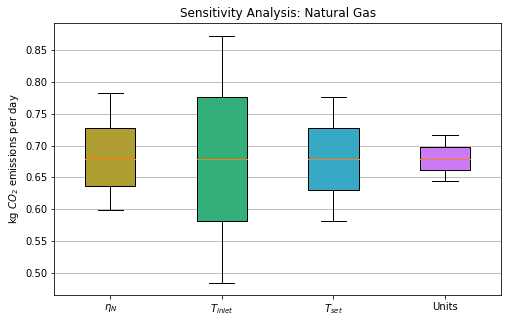

In [15]:
# Box plot:
data = [emissions_by_standby, emissions_by_T_cold, emissions_by_T_set, emissions_by_Units]
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['$\eta_N$', '$T_{inlet}$', '$T_{set}$', 'Units']
bplot = ax.boxplot(data, vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax.set_title('Sensitivity Analysis: Natural Gas')
# fill with colors
colors = [pal.as_hex()[i] for i in range(1,5)]
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.yaxis.grid(True)
ax.set_ylabel('kg $CO_2$ emissions per day')
plt.savefig('../img/Sensitivity_analysisNG.png',dpi = 200)

In [16]:
standby_uncertainty = statistics.stdev(emissions_by_standby)
tset_uncertainty = statistics.stdev(emissions_by_T_set)
tcold_uncertainty = statistics.stdev(emissions_by_T_cold)
unit_uncertainty =  statistics.stdev(emissions_by_Units)
uncertainties = [standby_uncertainty, tset_uncertainty, tcold_uncertainty, unit_uncertainty]

In [17]:
print(standby_uncertainty / sum(uncertainties))
print(tcold_uncertainty / sum(uncertainties))
print(tset_uncertainty / sum(uncertainties))
print(unit_uncertainty / sum(uncertainties))

0.2192584422788616
0.4634579402860985
0.23172897014304925
0.08555464729199067
